Import Libraries and Load Data

In [1]:
# Import necessary libraries
from sklearn import datasets
import pandas as pd

# Load the breast cancer dataset
cancer = datasets.load_breast_cancer()

# Print feature names and target names
print(f"Features: {cancer.feature_names}")
print("")
print(f"Target: {cancer.target_names}")



Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target: ['malignant' 'benign']


In [2]:

# Create a DataFrame from the dataset
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)

# Map target values to labels for better readability
df["target"] = cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Data Exploration

In [3]:
# Check the shape of the DataFrame
df.shape

(569, 31)

In [4]:


# Split the data into features (X) and target (y)
X = df.drop(columns=["target"])
y = df["target"]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of training and testing sets
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")


Train: (455, 30)
Test: (114, 30)


Define Objective Function for Optuna

Optuna is an open-source hyperparameter optimization framework for machine learning tasks. It provides a Python API to perform automated hyperparameter tuning, allowing you to efficiently search for the best set of hyperparameters for your machine learning models.

Here are some key points about Optuna:

- Optimization Objective: Optuna is primarily used for optimizing machine learning model hyperparameters to improve model performance on a specific task. The optimization objective is typically defined as a loss function or evaluation metric that you want to minimize or maximize.

- Search Algorithms: Optuna uses various optimization algorithms, such as Tree-structured Parzen Estimators (TPE), Gaussian Process-based Optimization (GPO), and others, to efficiently explore the hyperparameter space and find optimal hyperparameter configurations.

- Parallelization: Optuna supports parallelization, allowing you to distribute hyperparameter trials across multiple compute resources, which can significantly speed up the search process.

- Integration: It can be integrated with various machine learning frameworks and libraries like scikit-learn, PyTorch, TensorFlow, XGBoost, and more.

## Comparing Optuna with GridSearchCV and RandomizedSearchCV:

GridSearchCV: GridSearchCV performs an exhaustive search over a predefined set of hyperparameters. It evaluates all possible combinations of hyperparameters, making it suitable for small hyperparameter spaces. However, it can be computationally expensive for large hyperparameter spaces.

RandomizedSearchCV: RandomizedSearchCV randomly samples hyperparameters from predefined distributions. It explores a more diverse set of hyperparameters compared to GridSearchCV and is more suitable for large hyperparameter spaces. It is less computationally expensive than GridSearchCV.

Optuna: Optuna uses a more advanced optimization approach, considering the results of previous trials to make informed decisions about which hyperparameters to try next. It adapts and converges faster to an optimal solution, making it highly efficient for hyperparameter tuning, even in large and complex search spaces.

In [6]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [7]:
# Import additional libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import optuna

# Define an objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the Random Forest model
    n_estimators = trial.suggest_categorical('n_estimators', [30, 50, 100, 200])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 4, 8, step=1)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize the Random Forest model with suggested hyperparameters
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   criterion=criterion,
                                   max_depth=max_depth,
                                   max_features=max_features,
                                   n_jobs=-1)
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate F1 score as the optimization metric
    f1 = f1_score(y_test, y_pred)

    return f1


Optuna Hyperparameter Tuning

In [8]:
# Create an Optuna study for hyperparameter tuning
study = optuna.create_study(direction="maximize")

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and its hyperparameters
print(study.best_trial)
print(study.best_params)

# Visualize the optimization process
fig = optuna.visualization.plot_contour(study)
fig.show()


[I 2023-12-11 22:23:02,813] A new study created in memory with name: no-name-87e45a57-d4ad-49c9-b2e4-f82e48c9fbc3
[I 2023-12-11 22:23:04,530] Trial 0 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.9722222222222222.
[I 2023-12-11 22:23:05,089] Trial 1 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9722222222222222.
[I 2023-12-11 22:23:05,760] Trial 2 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 100, 'criterion': 'log_loss', 'max_depth': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.9722222222222222.
[I 2023-12-11 22:23:06,699] Trial 3 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0

FrozenTrial(number=34, state=TrialState.COMPLETE, values=[0.9859154929577465], datetime_start=datetime.datetime(2023, 12, 11, 22, 23, 21, 715037), datetime_complete=datetime.datetime(2023, 12, 11, 22, 23, 21, 987121), params={'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(30, 50, 100, 200)), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'max_depth': IntDistribution(high=8, log=False, low=4, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2'))}, trial_id=34, value=None)
{'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}


Optuna provides several visualization tools to help you interpret the optimization results:

**Contour Plot**: This plot visualizes the relationship between two hyperparameters while fixing the values of the others. It helps you understand how changing specific hyperparameters affects the optimization objective.

**EDF (Empirical Distribution Function) Plot**: This plot shows the cumulative distribution of the optimization metric across trials. It helps you assess how well the optimization process is progressing and whether it's converging to a good solution.

**Optimization History Plot:** This plot displays the optimization history, showing the values of the optimization metric at each trial. It helps you track the progress of the optimization process.

**Parallel Coordinate Plot:** This plot visualizes the hyperparameters' values for each trial, making it easy to compare different hyperparameter configurations.

**Parameter Importance Plot:** This plot ranks the importance of each hyperparameter based on their impact on the optimization metric.

Model Training and Evaluation

In [9]:
# Import additional libraries
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn import metrics

# Create a RandomForestClassifier with the best hyperparameters
model = RandomForestClassifier(**study.best_params, n_jobs=-1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Cross-validate the model
cv_results = cross_validate(model, X, y, cv=10)

# Get the test scores
test_scores = cv_results["test_score"]

# Calculate and print the average test score
avg_test_score = np.average(test_scores)
print(f"Average Test Score: {avg_test_score:.2f}")








Average Test Score: 0.97


In [10]:
# Calculate and print training and testing accuracy
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Testing Accuracy: 0.96


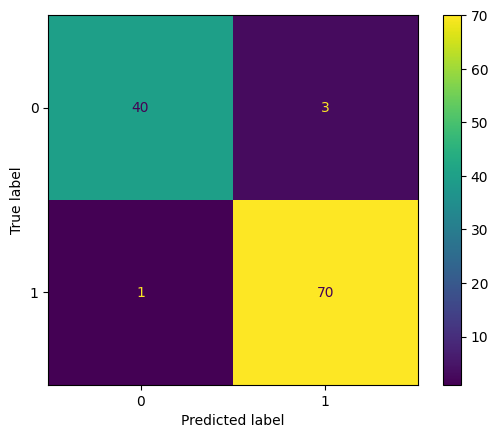

In [12]:
import matplotlib.pyplot as plt
# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate and display the confusion matrix
cm = metrics.confusion_matrix(y_test, predictions, labels=model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [13]:
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance
feature_imp = pd.DataFrame(sorted(zip(feature_importances, X_train.columns), reverse=True),
                           columns=['Value', 'Feature'])
feature_imp

,Value,Feature
0,0.145053,worst perimeter
1,0.141702,mean concave points
2,0.106753,worst concave points
3,0.099734,worst area
4,0.076737,worst radius
5,0.054071,mean perimeter
6,0.035055,mean texture
7,0.033746,area error
8,0.032762,mean radius
9,0.032454,mean concavity


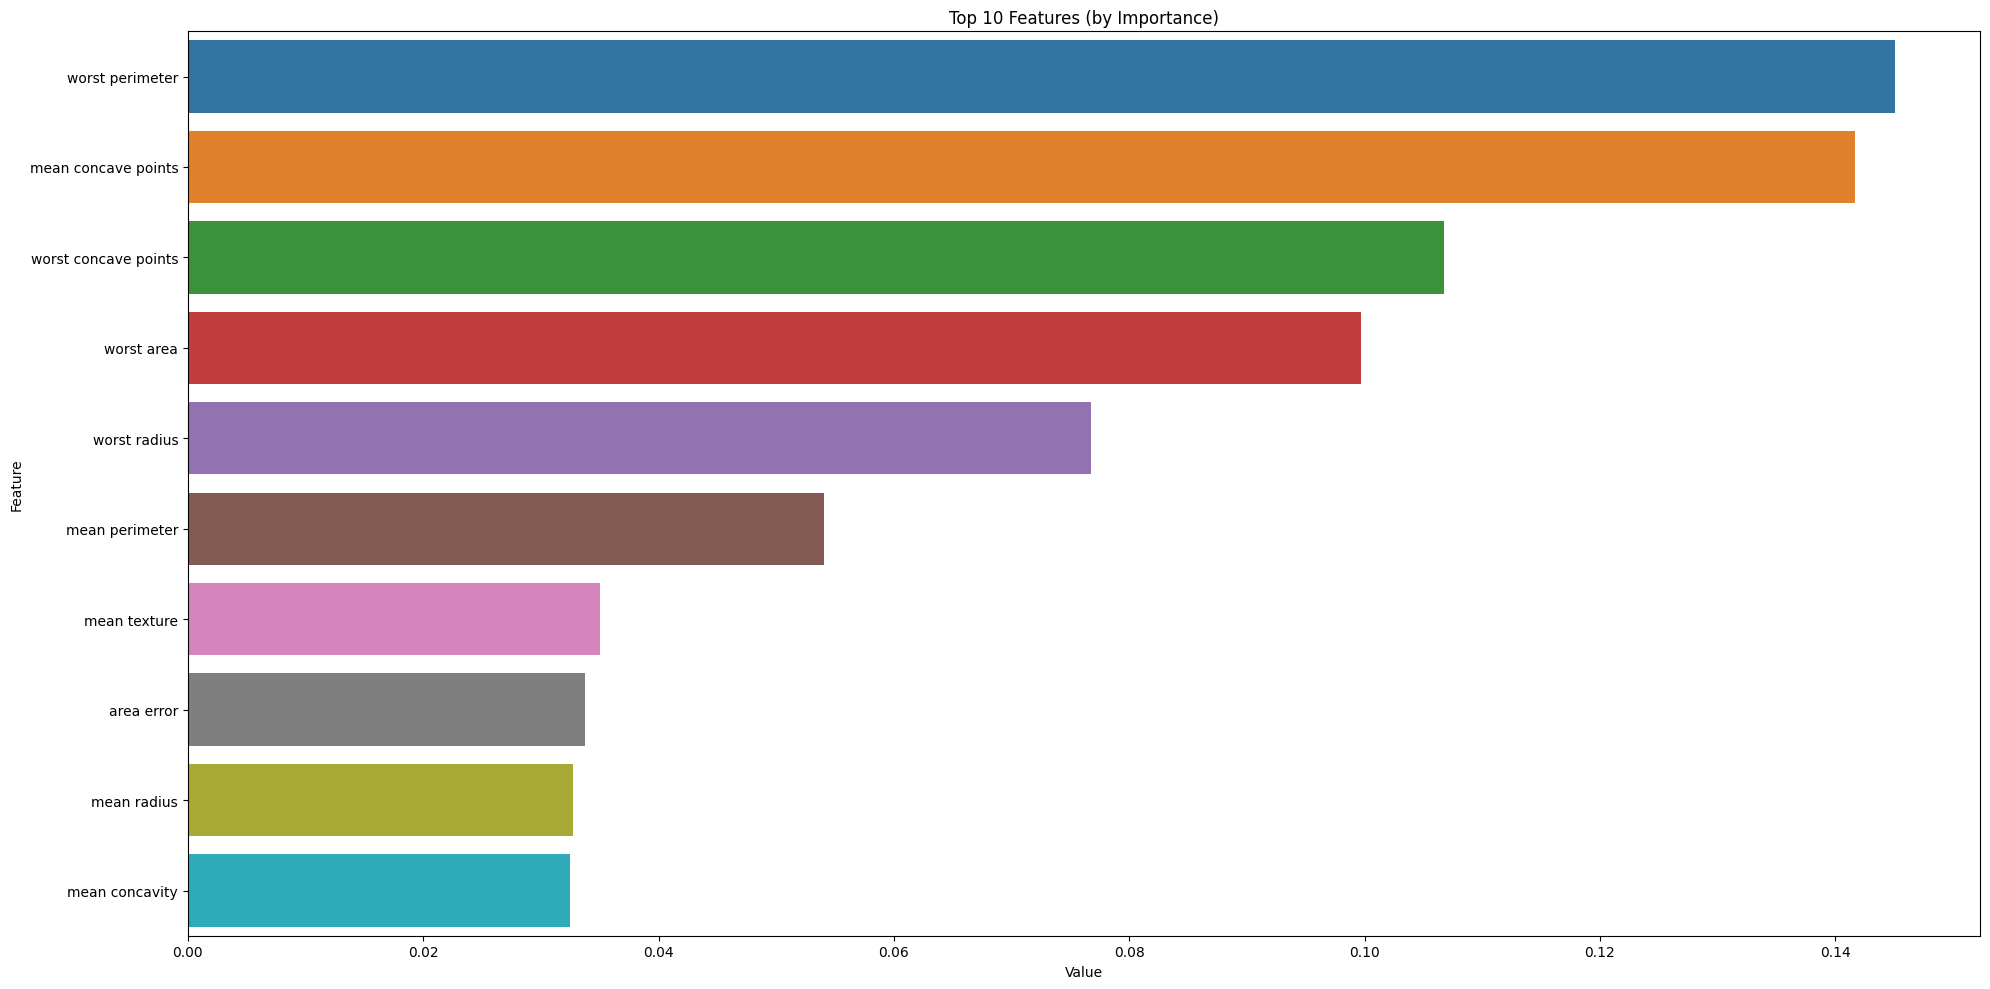

In [14]:


# Plot the top 10 features by importance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.head(10))
plt.title('Top 10 Features (by Importance)')
plt.tight_layout()
plt.show()